In [39]:
import xarray as xr
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
plt.style.use('/home/aos/kyan/.config/matplotlib/esm2m.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NEW Regrid to GFDL

In [23]:
# Open population density data (raster 5 = 2020 population density)
ds = xr.open_dataset('../data/processed/population_density.nc').sel(raster=5)
ds = ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 1 degree':'pop_dens'})
ds = ds.where(np.isfinite(ds['pop_dens']),0)

In [24]:
# Regrid population density data first to be 0-360, not -180-180
ds = ds.assign_coords({'longitude':ds['longitude']%360})

# Rename coordinates
ds = ds.rename({'longitude':'lon','latitude':'lat'})

In [36]:
# Open land area file with desired gridding, convert m^2 to km^2
ds_area = xr.open_dataset('../data/processed/GFDL/esm2m.land_area')['land_area']/(10**6)

In [38]:
# Regrid population density to match land area
ds_regrid = ds.interp_like(ds_area)

# Convert density to population count
ds_pop_regrid = (ds_regrid * ds_area).rename({'pop_dens':'population'})

In [40]:
ds_pop_regrid.to_netcdf('../data/processed/GFDL/population_regrid_esm2m_2.nc')

# NEW Regrid to CESM2

In [41]:
# Open population density data (raster 5 = 2020 population density)
ds = xr.open_dataset('../data/processed/population_density.nc').sel(raster=5)
ds = ds.rename({'UN WPP-Adjusted Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 1 degree':'pop_dens'})
ds = ds.where(np.isfinite(ds['pop_dens']),0)

In [42]:
# Regrid population density data first to be 0-360, not -180-180
ds = ds.assign_coords({'longitude':ds['longitude']%360})

# Rename coordinates
ds = ds.rename({'longitude':'lon','latitude':'lat'})

In [43]:
# Open land area file with desired gridding
ds_area = xr.open_dataarray('../data/processed/CESM2/cesm2.land_area').isel(ensemble=0)

In [44]:
# Regrid population density to match land area
ds_regrid = ds.interp_like(ds_area)

# Convert density to population count
ds_pop_regrid = (ds_regrid * ds_area).rename({'pop_dens':'population'})

In [45]:
ds_pop_regrid.to_netcdf('../data/processed/CESM2/population_regrid_cesm2_2.nc')

# Population Maps

In [10]:
pop_dens = xr.open_dataarray('../data/processed/population_density.nc').sel(raster=5)
pop_dens = pop_dens.rename({'longitude':'lon','latitude':'lat'})

Text(0.5, 1.0, 'UN WPP-adjusted Population Density, 2020')

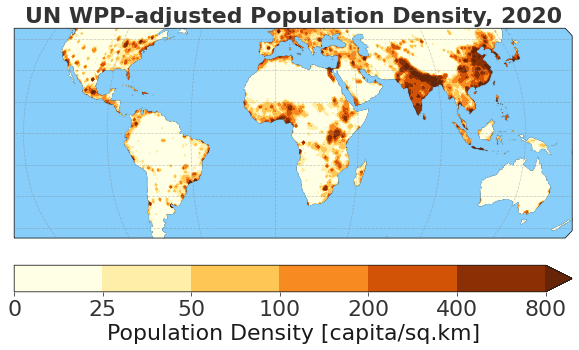

In [45]:
crs = ccrs.Robinson()
fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs})

# Specify variables
X = pop_dens['lon']
Y = pop_dens['lat']
Z = pop_dens.squeeze()
Z, X = add_cyclic_point(Z,coord=X)

cmap = plt.cm.get_cmap('YlOrBr', 12)
im = ax.contourf(X,Y,Z,levels=[0,25,50,100,200,400,800],colors=cmap(np.linspace(0,1,7)),transform=ccrs.PlateCarree(),extend='max')

ax.coastlines()
ax.add_feature(cfeature.OCEAN,zorder=1,facecolor='lightskyblue')
ax.set_extent([-140,160,-50,50],crs=ccrs.PlateCarree())
lf.grid(ax)

cbar = plt.colorbar(im,ax=ax,orientation='horizontal',fraction=0.05,pad=0.05)
cbar.set_label('Population Density [capita/sq.km]')

ax.set_title('UN WPP-adjusted Population Density, 2020',fontweight='bold')